# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

### Import useful libraries

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Standard libraries
import os
import re
import string
import copy
import json
import random
import zipfile
import requests
import urllib.request
from pathlib import Path
from collections import Counter

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
from wordcloud import WordCloud

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Machine learning metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    classification_report,
    auc
)
from sklearn.metrics import PrecisionRecallDisplay

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Hugging Face Transformers
from transformers import (
    AutoModelForSequenceClassification,
    TFAutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorWithPadding,
    Trainer
)
from scipy.special import softmax

# Datasets
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Create train, validation and test DataFrames
 * Download json files *test.json*, *training.json* and *validation.json* from [here](https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/).
 * Load the json files into pandas DataFrames

In [3]:
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/"
json_files = ["test.json", "training.json", "validation.json"]
local_dir = Path("Assignment%201/data")
local_dir.mkdir(parents=True, exist_ok=True)

# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        data = json.load(file)
        dataframes[file_name] = pd.DataFrame(data)


# Load the original datasets from the specified JSON files into separate DataFrames
original_train_df = dataframes['training.json']
original_validation_df = dataframes['validation.json']
original_test_df = dataframes['test.json']

Downloaded test.json
Downloaded training.json
Downloaded validation.json


### Transform the DataFrames as requested

In [4]:
def determine_majority(response_list):
    """
    Counts the occurrences of "YES" and "NO" in the input list and returns:
      - 1 if "YES" is the majority,
      - 0 if "NO" is the majority,
      - 2 if there is a tie.
    """
    yes_count = response_list.count("YES")
    no_count = response_list.count("NO")
    if yes_count > no_count:
        return 1
    elif no_count > yes_count:
        return 0
    else:
        return 2


def transform_df(df):
    """
    - Transposes the DataFrame.
    - Adds a column `hard_label_task1` based on the majority label in `labels_task1`.
    - Filters rows where `lang` is 'en' and excludes rows where `hard_label_task1` equals 2(tie).
    - Selects specific columns for the final output.
    """
    df = df.T
    df['hard_label_task1'] = df['labels_task1'].apply(determine_majority)
    df = df[df['lang'] == 'en']
    df = df[df['hard_label_task1'] != 2]
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
    return df


In [5]:
# Apply the `transform_df` function to preprocess the training, validation, and test DataFrames
original_train_df = transform_df(original_train_df)
original_validation_df = transform_df(original_validation_df)
original_test_df = transform_df(original_test_df)

original_train_df

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0
...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,1
203257,203257,en,This has been a part of an experiment with @Wo...,1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...",1
203259,203259,en,@clintneedcoffee why do you look like a whore?...,1


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [6]:
# Create copies of the original datasets to avoid modifying them directly
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

### Perform Data Cleaning
 * Remove emojis
 * Remove hashtags
 * Remove mentions
 * Remove URLs
 * Remove special characters and symbols
 * Remove specific quote characters
 * Convert to lowercase
 * Tokenize the tweet
 * Remove stopwords
 * Lemmatize the word


In [7]:
# Initialize the WordNet lemmatizer for reducing words to their base form
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    """
    Cleans a tweet by removing unwanted characters, URLs, hashtags, mentions, and stopwords,
    and by performing lemmatization.
    """
    # Remove non-ASCII characters
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove non-alphanumeric characters (except spaces)
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Remove specific quote characters
    tweet = tweet.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')
    # Convert to lowercase
    tweet = tweet.lower()
    # Tokenize the text
    words = word_tokenize(tweet)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join the cleaned words back into a single string
    cleaned_tweet = ' '.join(words)

    return cleaned_tweet

# Apply the `clean_tweet` function to the tweet column in the training, validation, and test datasets
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)


In [8]:
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,writing uni essay local pub coffee random old ...,1
200003,200003,en,2021 1921 dont appreciate two ride team member...,1
200006,200006,en,according customer plenty time go spent stirli...,1
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1
200008,200008,en,new shelf week looking forward reading book,0


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

### Download and extract GloVe embeddings with dimension of 100.

In [9]:
def download_glove_embeddings(glove_url, save_path='glove.zip', extract_path='glove'):
    """
    Downloads and extracts GloVe embeddings if not already present.
    """
    # Check if the embeddings are already extracted
    if not os.path.exists(extract_path):
        print("Downloading GloVe embeddings...")

        # Stream download with progress bar
        response = requests.get(glove_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            # Write the content in chunks and update the progress bar
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
                bar.update(len(data))

        print("Extracting GloVe embeddings...")
        # Extract the zip file to the specified directory
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        # Clean up by removing the downloaded zip file
        os.remove(save_path)
        print("Download and extraction complete.")
    else:
        print("GloVe embeddings already downloaded.")


def load_glove_embeddings(filepath, embedding_dim=100):
    """
    Loads GloVe embeddings into a dictionary.
    """
    embeddings = {}
    print(f"Loading GloVe embeddings from {filepath}...")
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            # Split the line into word and its embedding vector
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print("GloVe embeddings loaded.")
    return embeddings


# URL for the GloVe embeddings file
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
# Path to save and extract the GloVe embeddings
download_path = 'glove.6B.zip'
extract_path = 'glove'

# Download and extract GloVe embeddings
download_glove_embeddings(glove_url, download_path, extract_path)

# Define the embedding dimension
embedding_dim = 100
# Path to the specific GloVe file for the desired dimension
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')

# Load the embeddings into memory
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)


Downloading: 100%|██████████| 822M/822M [02:38<00:00, 5.42MB/s]


Extracting GloVe embeddings...
Download and extraction complete.
Loading GloVe embeddings from glove/glove.6B.100d.txt...
GloVe embeddings loaded.
Loaded GloVe embeddings with dimension: 100


### Pad the tweets to have them of the same lenght.

In [107]:
def find_series_max_len(series_list):
    """
    Finds the maximum number of words in any entry across multiple pandas Series.
    """
    # Concatenate all Series into a single Series
    all_text = pd.concat(series_list, ignore_index=True)
    # Calculate the word count for each entry
    word_count = all_text.apply(lambda x: len(str(x).split()))
    max_word_count = word_count.max()
    return max_word_count


def pad_text_column(df, column_name, max_len, pad_token="<PAD>"):
    """
    Pads or truncates text in a specified column to a uniform length.
    """
    # Tokenize the text if not already tokenized
    df['padded_' + column_name] = df[column_name].apply(
        lambda x: x if isinstance(x, list) else str(x).split()
    )
    # Pad or truncate each text entry to the specified length
    df['padded_' + column_name] = df['padded_' + column_name].apply(
        lambda x: x[:max_len] + [pad_token] * (max_len - len(x)) if len(x) < max_len else x[:max_len]
    )
    return df


# Find the maximum length of tweets across train, validation, and test datasets
MAX_LEN = find_series_max_len([train_df['tweet'], validation_df['tweet'], test_df['tweet']])
print(f"Maximum length found: {MAX_LEN}")

# Pad the 'tweet' column in train, validation, and test DataFrames
train_df = pad_text_column(train_df, 'tweet', MAX_LEN)
validation_df = pad_text_column(validation_df, 'tweet', MAX_LEN)
test_df = pad_text_column(test_df, 'tweet', MAX_LEN)

# Print the first padded tweet from the training DataFrame
print(train_df['padded_tweet'].iloc[0])


Maximum length found: 78
['Writing', 'a', 'uni', 'essay', 'in', 'my', 'local', 'pub', 'with', 'a', 'coffee.', 'Random', 'old', 'man', 'keeps', 'asking', 'me', 'drunk', 'questions', 'when', "I'm", 'trying', 'to', 'concentrate', '&amp;', 'ends', 'with', '"good', 'luck,', 'but', "you'll", 'just', 'end', 'up', 'getting', 'married', 'and', 'not', 'use', 'it', 'anyway".', '#EverydaySexism', 'is', 'alive', 'and', 'well', '🙃', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


### Build the vocabulary and the embeddings on the train set.

In [108]:
# Tokenize tweets and build vocabulary
def build_vocab_and_embeddings(data, embeddings_index, embedding_dim):
    vocab = {}
    word_embeddings = []
    for tweet in data['padded_tweet']:
        for token in tweet:
            if token not in vocab:
                # Check if the token has a pre-trained embedding, otherwise default to random
                embedding = embeddings_index.get(token, np.random.uniform(-0.1, 0.1, embedding_dim))
                vocab[token] = len(vocab)
                word_embeddings.append(embedding)
    return vocab, word_embeddings

# Build vocabulary and embeddings for the training set
vocab, word_embeddings = build_vocab_and_embeddings(train_df, glove_embeddings, embedding_dim)

### Set the embedding for the Unknown words.

In [109]:
# Special handling for the '[UNK]' token (unknown token)
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)

# Compute the embedding for the unknown token as the mean of all word embeddings
unk_embedding = np.mean(word_embeddings, axis=0)
word_embeddings = np.vstack([word_embeddings, unk_embedding])

### Embed train, validation and test sets.

In [110]:
def embed_tweet(df, vocab, word_embeddings):
    """
    Converts tokens in a tweet dataframe to their corresponding word embeddings.
    Out-of-vocabulary (OOV) tokens are replaced with the embedding of '[UNK]'.
    """
    data = df.copy()
    new_tweet = []
    for tweet in data['padded_tweet']:
        embedded_tweet = []
        for token in tweet:
            if token not in vocab:
                # token is OOV so considered UNK
                embedded_tweet.append(word_embeddings[vocab['[UNK]']])
            else:
                embedded_tweet.append(word_embeddings[vocab[token]])
        new_tweet.append(embedded_tweet)
    data['padded_tweet'] = new_tweet
    return data

# Embed all the df with our extended GloVe embeddings
train_df_embedded = embed_tweet(train_df, vocab, word_embeddings)
validation_df_embedded = embed_tweet(validation_df, vocab, word_embeddings)
test_df_embedded = embed_tweet(test_df, vocab, word_embeddings)

train_df_embedded.head()

,id_EXIST,lang,tweet,hard_label_task1,padded_tweet
200002,200002,en,Writing a uni essay in my local pub with a cof...,1,"[[0.009762700785464956, 0.043037873274483884, ..."
200003,200003,en,@user it is 2021 not 1921. I dont appreciate t...,1,"[[-0.019812006977444563, 0.0508080878834144, -..."
200006,200006,en,According to a customer I have plenty of time ...,1,"[[0.02031200059512897, 0.0027068334468007132, ..."
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1,"[[-0.04026043096325365, 0.049457869797384035, ..."
200008,200008,en,New to the shelves this week - looking forward...,0,"[[-0.07513933547096144, -0.04765170694799199, ..."


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Bidirectional LSTM with a Dense layer on top.
In the code: lstm_out has shape `[batch, seq_len, hidden_size * 2]`.<br>
Being bidirectional, the hidden state is the concatenation of the last forward and backward hidden states.

In [111]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True):
        super(BiLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        # for bidirectional: lstm_out has shape [batch, seq_len, hidden_size * 2]
        lstm_out, (hidden, cell) = self.lstm(x)

        if self.lstm.bidirectional:
            # concatenate the last forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        out = self.fc(hidden)
        return out.view(-1)

### Initialize the baseline model

In [118]:
input_size = 100
hidden_size = 128
num_layers = 1
output_size = 1

baseline_model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

### Initialize Model 1
Being the baseline model with an additional LSTM layer, we have to specify only that `num_layers` has to be 2.



In [119]:
num_layers = 2

model_1 = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

### Definition of a `CustomTrainer`
The trainer trains the given model on the different seeds given in input and plots the learning curve across the seeds. <br>
The `get_error()` function creates a DataFrame with the errors done on the dataset given in input.

In [120]:
class CustomTrainer:
    """
    Custom trainer class for training and evaluating a model with various configurations and reproducibility.
    """
    def __init__(self, model, output_size=5, learning_rate=0.001, num_epochs=20, batch_size=32, seed=42):
        self.set_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}", end='\n\n')

        self.model = model.to(self.device)
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def set_seed(self, seed):
        """Set the seed for reproducibility."""

        random.seed(seed)
        np.random.seed(seed)
        # PyTorch CPU
        torch.manual_seed(seed)
        # PyTorch GPU (or GPUs)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        # disable the auto-tuner to avoid randomness
        torch.backends.cudnn.benchmark = False
        self.seed = seed


    def train(self, train_df):
        """ Train the model on the given training data."""

        self.x_train = torch.tensor(train_df['padded_tweet'], dtype=torch.float32).to(self.device)
        self.y_train = torch.tensor(train_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        self.train_dataset = TensorDataset(self.x_train, self.y_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        losses = []
        for epoch in tqdm(range(self.num_epochs), desc=f'Training with seed {self.seed}'):
            self.model.train()
            running_loss = 0.0

            for batch_idx, (inputs, labels) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                # forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                # backward pass
                loss.backward()
                # optimization
                self.optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(self.train_loader)
            losses.append(avg_loss)
        return losses

    def test(self, test_df):
        """ Evaluate the model on the given test data."""

        x_test = torch.tensor(test_df['padded_tweet'], dtype=torch.float32).to(self.device)
        y_test = torch.tensor(test_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        test_dataset = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()

        all_probs = []
        all_labels = []
        error_texts = []
        error_labels = []

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(test_loader):
                outputs = self.model(inputs)
                predicted = torch.round(torch.sigmoid(outputs))

                # Find wrong predictions (where the predicted label does not match the true label)
                incorrect_idx = (predicted.squeeze() != labels).nonzero(as_tuple=True)[0]

                # Save the texts and corresponding labels for incorrect predictions
                if len(incorrect_idx) > 0:
                    for idx in incorrect_idx:
                        error_texts.append(test_df['tweet'][batch_idx * self.batch_size + idx.item()])
                        error_labels.append(labels[idx].item())

                all_probs.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # flatten the lists
        all_probs = np.concatenate(all_probs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Inference of all_preds from all_probs (using a threshold of 0.5 for binary classification)
        all_preds = (all_probs >= 0.5).astype(int)
        # calculate f1-score and accuracy
        f1 = f1_score(all_labels, all_preds, average='macro')
        accuracy = (all_preds == all_labels).mean()

        errors_df = pd.DataFrame({
            'tweet': error_texts,
            'label': error_labels
            })

        return accuracy, f1, all_probs, all_labels, errors_df


    def train_and_evaluate_multiple_seeds(self, train_df, test_df, num_seeds=5):
        """ Train and evaluate the model multiple times with different seeds."""
        all_losses = []
        all_accuracies = []

        untrained_model = copy.deepcopy(self.model.state_dict())

        print(f"### Start training and testing with {num_seeds} seeds ###")
        # loop through multiple seeds
        for seed in range(num_seeds):
            self.set_seed(seed)

            # train and evaluate the model
            epoch_losses = self.train(train_df)
            accuracy, f1, _, _, _ = self.test(test_df)

            self.model.load_state_dict(untrained_model)

            print(f"Accuracy on val: {accuracy:.4f}, f1-score on val: {f1:.4f}", end="\n\n")
            all_losses.append(epoch_losses)
            all_accuracies.append(accuracy)

        all_losses = np.array(all_losses)
        all_accuracies = np.array(all_accuracies)

        # plot the learning curves: max, min, avg loss across all seeds
        self.plot_learning_curve(all_losses, all_accuracies)


    def plot_learning_curve(self, all_losses, all_accuracies):
        """Plot the learning curve across all seeds."""
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(all_losses.mean(axis=0), label='Avg Loss', color='blue')
        plt.fill_between(range(len(all_losses[0])), all_losses.min(axis=0), all_losses.max(axis=0), color='blue', alpha=0.2)
        plt.title('Learning Curve (Loss)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    """def get_errors(self, test_df):
        Create a DataFrame with the errors of the model on the given dataset.

        x_test = torch.tensor(test_df['padded_tweet'], dtype=torch.float32).to(self.device)
        y_test = torch.tensor(test_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        texts = test_df['tweet']

        test_dataset = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()

        all_preds = []
        all_labels = []
        error_texts = []
        error_labels = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                outputs = self.model(inputs)
                predicted = torch.round(torch.sigmoid(outputs))
                for i, (pred, label) in enumerate(zip(predicted.cpu().numpy(), labels.cpu().numpy())):
                    if not np.array_equal(pred, label):
                        error_texts.append(texts.iloc[idx * self.batch_size + i])
                        error_labels.append(label)

        errors_df = pd.DataFrame({
            'tweet': error_texts,
            'label': error_labels
            })

        return errors_df"""

### Train and evaluate the baseline model.

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


Accuracy on val: 0.7278, f1-score on val: 0.7082



Training with seed 1: 100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


Accuracy on val: 0.7658, f1-score on val: 0.7506



Training with seed 2: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


Accuracy on val: 0.7658, f1-score on val: 0.7506



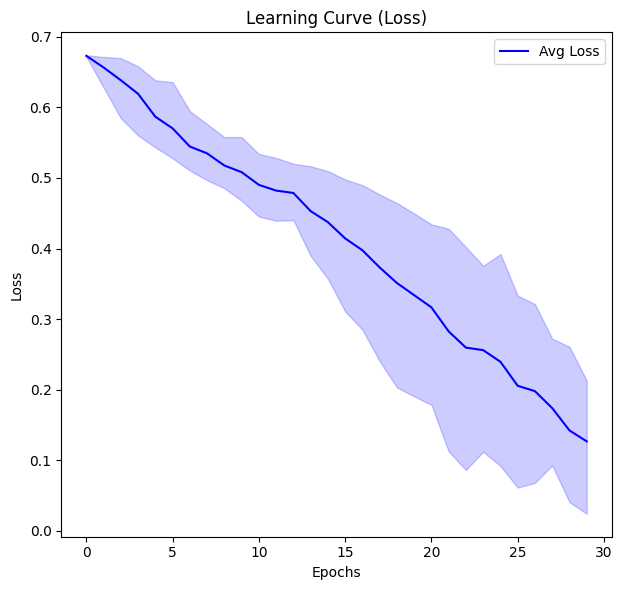



BASELINE MODEL:
Accuracy on test: 0.5594, f1-score on test: 0.3587



In [121]:
baseline_trainer = CustomTrainer(model=baseline_model, num_epochs=30, batch_size=32, learning_rate=0.001)

baseline_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)

baseline_accuracy, baseline_f1, baseline_probs, baseline_labels, baseline_error_df = baseline_trainer.test(test_df_embedded)
print('\n\nBASELINE MODEL:')
print(f"Accuracy on test: {baseline_accuracy:.4f}, f1-score on test: {baseline_f1:.4f}", end="\n\n")

### Get the error DataFrame for the baseline model.

In [122]:
#baseline_error_df = baseline_trainer.get_errors(test_df_embedded)

### Train and evaluate Model 1.

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


Accuracy on val: 0.7405, f1-score on val: 0.7103



Training with seed 1: 100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


Accuracy on val: 0.7215, f1-score on val: 0.6627



Training with seed 2: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


Accuracy on val: 0.7785, f1-score on val: 0.7641



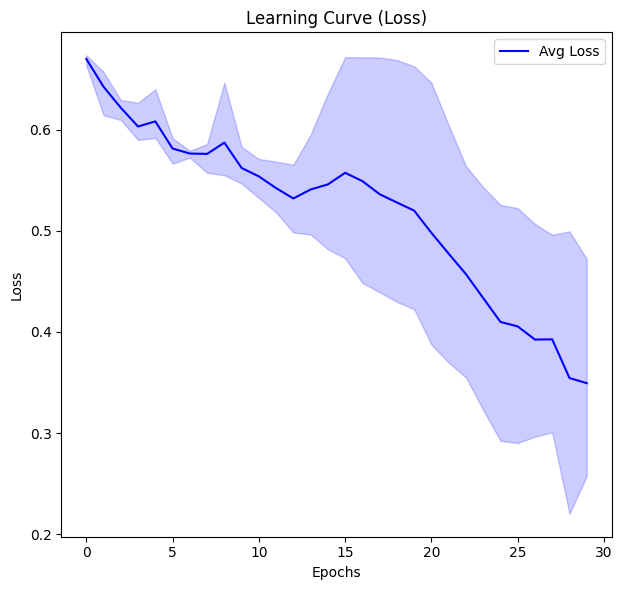



MODEL 1:
Accuracy on test: 0.5594, f1-score on test: 0.3587



In [123]:
model_1_trainer = CustomTrainer(model=model_1, num_epochs=30, batch_size=32, learning_rate=0.001)

model_1_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)
model_1_accuracy, model_1_f1, model_1_probs, model_1_labels, model_1_error_df = model_1_trainer.test(test_df_embedded)
print('\n\nMODEL 1:')
print(f"Accuracy on test: {model_1_accuracy:.4f}, f1-score on test: {model_1_f1:.4f}", end="\n\n")

### Get the error DataFrame for model 1.

In [124]:
# model_1_error_df = model_1_trainer.get_errors(test_df_embedded)

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [125]:
# Create copies of the original datasets to avoid modifying them directly
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

### Preprocess the tweets
Replace the usernames with *user* and the links with *http*

In [126]:
def preprocess(text):
    """
    Preprocesses the input text by replacing user mentions with '@user' and URLs with 'http'
    """
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Apply the preprocessing function to the 'tweet' column
train_df['tweet'] = train_df['tweet'].apply(preprocess)
validation_df['tweet'] = validation_df['tweet'].apply(preprocess)
test_df['tweet'] = test_df['tweet'].apply(preprocess)
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@user it is 2021 not 1921. I dont appreciate t...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


### Define the model and the tokenizer
Use the Twitter-roBERTa-base for Hate Speech Detection model as requested.

In [127]:
# Define the task type (e.g., 'hate' for hate speech classification)
task = 'hate'

# Set the model name based on the task type
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load the pre-trained transformer model for sequence classification
transformer_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Save the model to the local directory for future use
transformer_model.save_pretrained(MODEL)

OSError: Can't load tokenizer for 'cardiffnlp/twitter-roberta-base-hate'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'cardiffnlp/twitter-roberta-base-hate' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.

### Tokenize the tweets.

In [128]:
def preprocess_text(texts):
    # Use the tokenizer to process the 'tweet' column and apply truncation to handle long texts
    return tokenizer(texts['tweet'], truncation=True)

# Convert the training, validation, and test dataframes into HuggingFace Dataset objects
train_data = Dataset.from_pandas(train_df)
validation_data = Dataset.from_pandas(validation_df)
test_data = Dataset.from_pandas(test_df)

# Apply the preprocessing function to the dataset, using the 'batched' option to process in batches
train_data = train_data.map(preprocess_text, batched=True)
validation_data = validation_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

# Show the processed training data
train_data


Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})

In [129]:
# Rename the label columns to match with transformer default
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

In [130]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Define the traning arguments.

In [131]:
transformer_training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate=1e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none'
)

In [132]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [133]:
transformer_trainer = Trainer(
    model=transformer_model,
    args=transformer_training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### Train the transformer model.

In [134]:
transformer_trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.410700,0.435926,0.855552,0.860759
2,0.426800,0.482667,0.855552,0.860759
3,0.441300,0.519390,0.855552,0.860759
4,0.423100,0.539042,0.861767,0.867089


TrainOutput(global_step=2872, training_loss=0.43976458599972523, metrics={'train_runtime': 602.0831, 'train_samples_per_second': 19.067, 'train_steps_per_second': 4.77, 'total_flos': 382640557810440.0, 'train_loss': 0.43976458599972523, 'epoch': 4.0})

### Compute f1-score and accuracy on the test set.

In [135]:
# Use the trained transformer model to make predictions on the test data
transformer_test_prediction_info = transformer_trainer.predict(test_data)

# Extract the model predictions and the true labels from the prediction result
transformer_test_predictions, transformer_test_labels = transformer_test_prediction_info.predictions, transformer_test_prediction_info.label_ids

In [136]:
# Compute the evaluation metrics (such as F1 score and accuracy) for the test predictions
transformer_test_metrics = compute_metrics([transformer_test_predictions, transformer_test_labels])

# Extract the F1 score and accuracy from the computed metrics
transformer_f1 = transformer_test_metrics['f1']
transformer_accuracy = transformer_test_metrics['acc']

print(f"Accuracy on test: {transformer_accuracy:.4f}\nf1-score on test: {transformer_f1:.4f}", end="\n\n")

Accuracy on test: 0.8112
f1-score on test: 0.8096



# COSE DA FARE

 ### ERROR ANALYSIS
 FAQ: <br>
 Some topics for discussion include:
   * Precision/Recall curves. ✅
   * Confusion matrices. ✅
   * Specific misclassified samples. ✅

NOSTRE: <br>
 * Nelle frasi sbagliate, printare la frase con i token che non sono nel vocabolario colorati di rosso. ✅
 * Controllo delle distribuzioni del dataset (bilanciato?) ✅
 * Discutere gli errori comuni e le performance


 ### IDEE EXTRA
  * Usare embedding trainabili invece di globe
  * Mantenere le emojy e hashtag nel testo dei tweet
  * Usare tokenizer nel primo task


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



#### Start with an analysis of the dataset to see the data

In [137]:
# Assign the DataFrames to variables for consistency
data_train = train_df
data_val = validation_df
data_test = test_df

# Rename the 'hard_label_task1' column to 'label' in the datasets for consistency
data_train = data_train.rename(columns={'hard_label_task1': 'label'})
data_val = data_val.rename(columns={'hard_label_task1': 'label'})
data_test = data_test.rename(columns={'hard_label_task1': 'label'})

Plot the distribution of the labels in the train, validation and test sets.

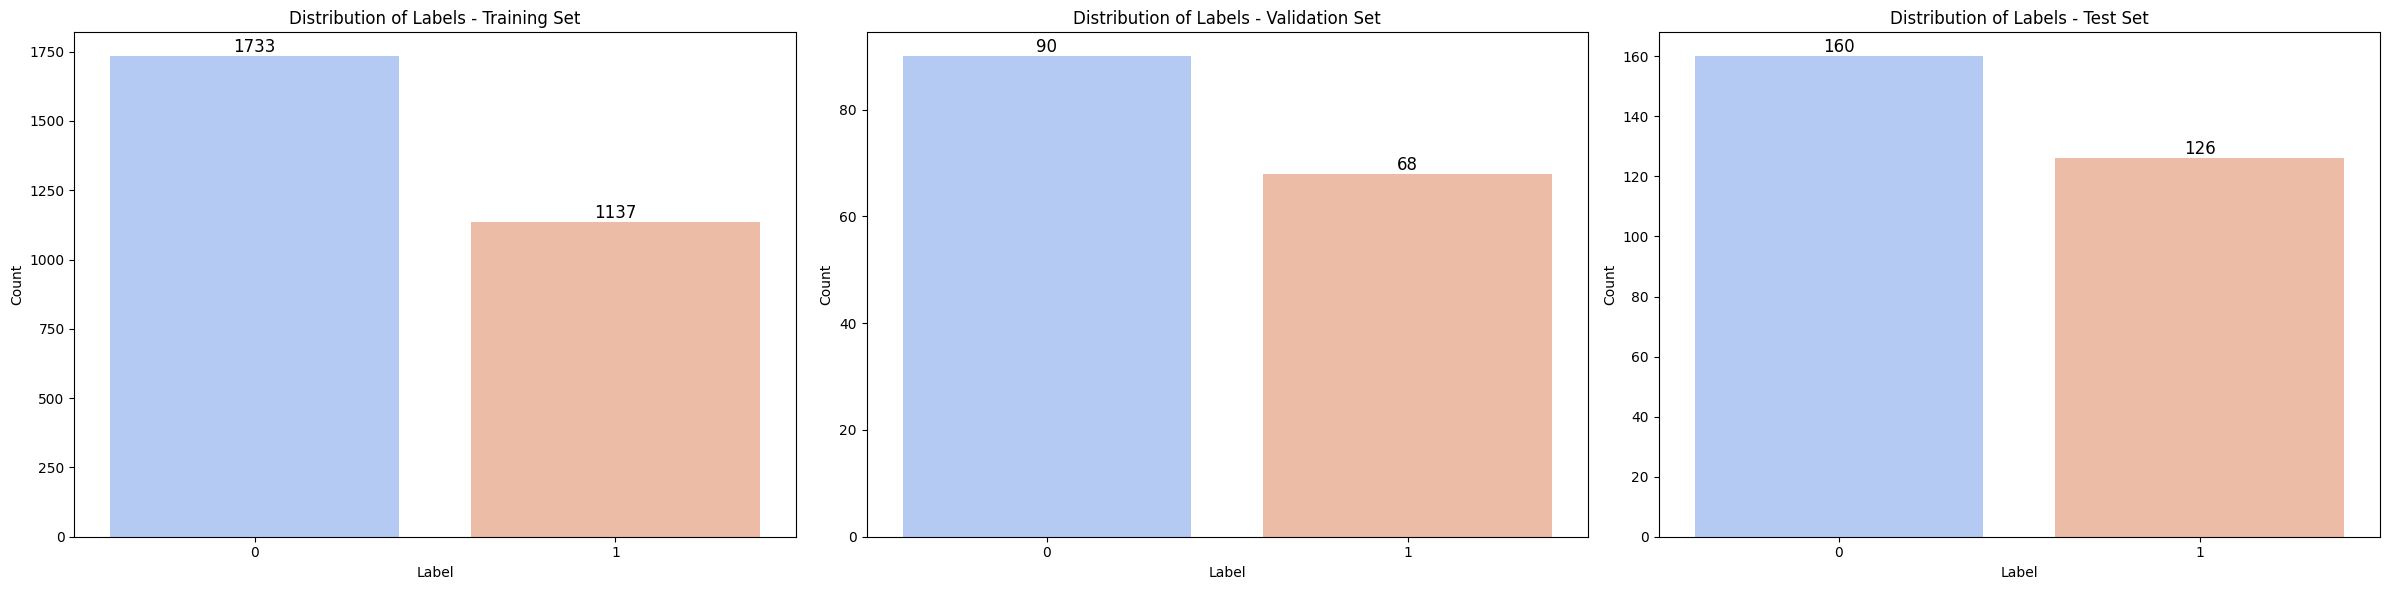

In [138]:
def plot_label_distribution(data_list, labels):
    n = len(data_list)  # Get the number of datasets
    plt.figure(figsize=(n * 8, 6))  # Adjust the figure size based on the number of datasets

    for i in range(n):
        data = data_list[i]

        # Create subplot
        ax = plt.subplot(1, n, i + 1)  # 1 row, n columns, position i+1
        sns.countplot(data=data, x='label', palette='coolwarm', ax=ax)
        plt.title(f'Distribution of Labels - {labels[i]}')
        plt.xlabel('Label')
        plt.ylabel('Count')

        # Annotate each bar with the exact count value
        for patch in ax.patches:
            height = patch.get_height()  # Get the height of the bar (count)
            ax.text(patch.get_x() + patch.get_width() / 2, height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=12)  # Position the text

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


plot_label_distribution([data_train, data_val, data_test], labels=['Training Set', 'Validation Set', 'Test Set'])

Plot the train, validation and test set distribution of the tweet lenght.

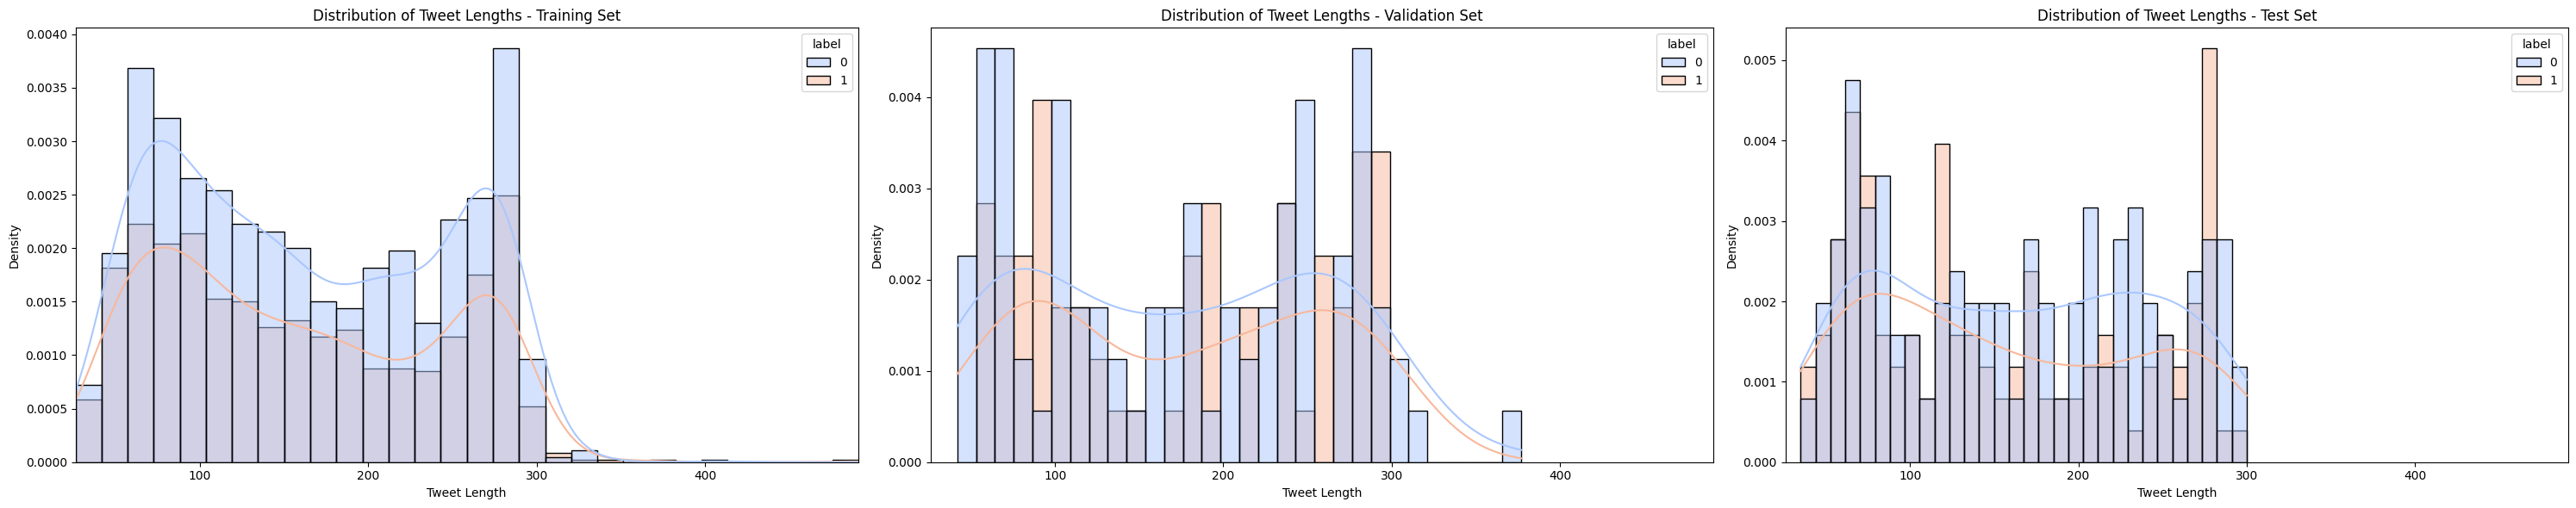

In [139]:
def plot_distr_tweet_len(data_list_or, labels):
    data_list = []
    for data_or in data_list_or:
        data = data_or.copy()
        data['tweet_length'] = data['tweet'].apply(len)
        data_list.append(data)

    # Determine global x and y axis limits
    all_lengths = pd.concat([data['tweet_length'] for data in data_list])
    x_min, x_max = all_lengths.min(), all_lengths.max()

    # Determine the number of datasets
    n = len(data_list)

    # Create a single figure with subplots arranged in 1 row and n columns
    plt.figure(figsize=(n * 10, 6))  # Adjust the figure size based on the number of datasets

    for i, data in enumerate(data_list):
        ax = plt.subplot(1, n, i + 1)  # 1 row, n columns, position i+1
        sns.histplot(data, x='tweet_length', hue='label', bins=30, kde=True, palette='coolwarm', ax=ax, stat='density')
        ax.set_title(f'Distribution of Tweet Lengths - {labels[i]}')
        ax.set_xlabel('Tweet Length')
        ax.set_ylabel('Density')  # Density instead of Frequency
        ax.set_xlim(x_min, x_max)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

plot_distr_tweet_len([data_train, data_val, data_test], labels=['Training Set', 'Validation Set', 'Test Set'])


Plot the most frequent words for each label

In [140]:
def analyze_top_words_by_label(data, text_column='tweet', label_column='label', n_top_words=20, excluded_words=set()):
    """
    Analyzes the most frequent words in a dataset, grouped by a specific label. This function preprocesses the text data,
    tokenizes the text, removes stopwords (including custom exclusions), and visualizes the top 'n' words for each label.
    """
    # Ensure the input data has the required columns
    if text_column not in data.columns or label_column not in data.columns:
        raise ValueError(f"Dataframe must contain '{text_column}' and '{label_column}' columns.")

    # Define stop words (including custom exclusions and punctuation)
    stop_words = set(stopwords.words('english') + list(string.punctuation) + list(excluded_words))

    # Preprocessing function to clean and tokenize the text
    def preprocess_text(text):
        tokens = word_tokenize(text.lower())  # Tokenize and convert to lower case
        filtered_words = [word for word in tokens if word not in stop_words and word.isalnum()]
        return ' '.join(filtered_words)

    # Apply preprocessing to the text column
    data['cleaned_text'] = data[text_column].apply(preprocess_text)

    # Function to extract top n words from a collection of texts
    def get_top_words(texts, n=20):
        all_words = ' '.join(texts).split()
        most_common = Counter(all_words).most_common(n)
        return pd.DataFrame(most_common, columns=['word', 'count'])

    # Initialize dictionary for storing top words by label and find max count for consistent axis scaling
    max_count = 0
    label_top_words = {}

    for label in data[label_column].unique():
        # Filter data by label
        subset = data[data[label_column] == label]
        top_words = get_top_words(subset['cleaned_text'], n=n_top_words)
        top_words = top_words[~top_words['word'].isin(excluded_words)]  # Exclude unwanted words

        # Store the top words for the label and update max count for consistent plotting
        label_top_words[label] = top_words
        if not top_words.empty:
            max_count = max(max_count, top_words['count'].max())

    # Determine the number of rows and columns for subplots
    num_labels = len(label_top_words)
    num_cols = 2
    num_rows = (num_labels + num_cols - 1) // num_cols  # This ensures enough rows to fit all plots

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 8))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Plot top words for each label
    for idx, (label, top_words) in enumerate(label_top_words.items()):
        if not top_words.empty:
            sns.barplot(data=top_words, x='count', y='word', palette='coolwarm', ax=axes[idx])
            axes[idx].set_title(f"Top Words for Label: {label}")
            axes[idx].set_xlabel('Count')
            axes[idx].set_ylabel('Word')
            axes[idx].set_xlim(0, max_count + 5)  # Adding a small margin for better visuals

    # Remove any unused axes
    for j in range(num_labels, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

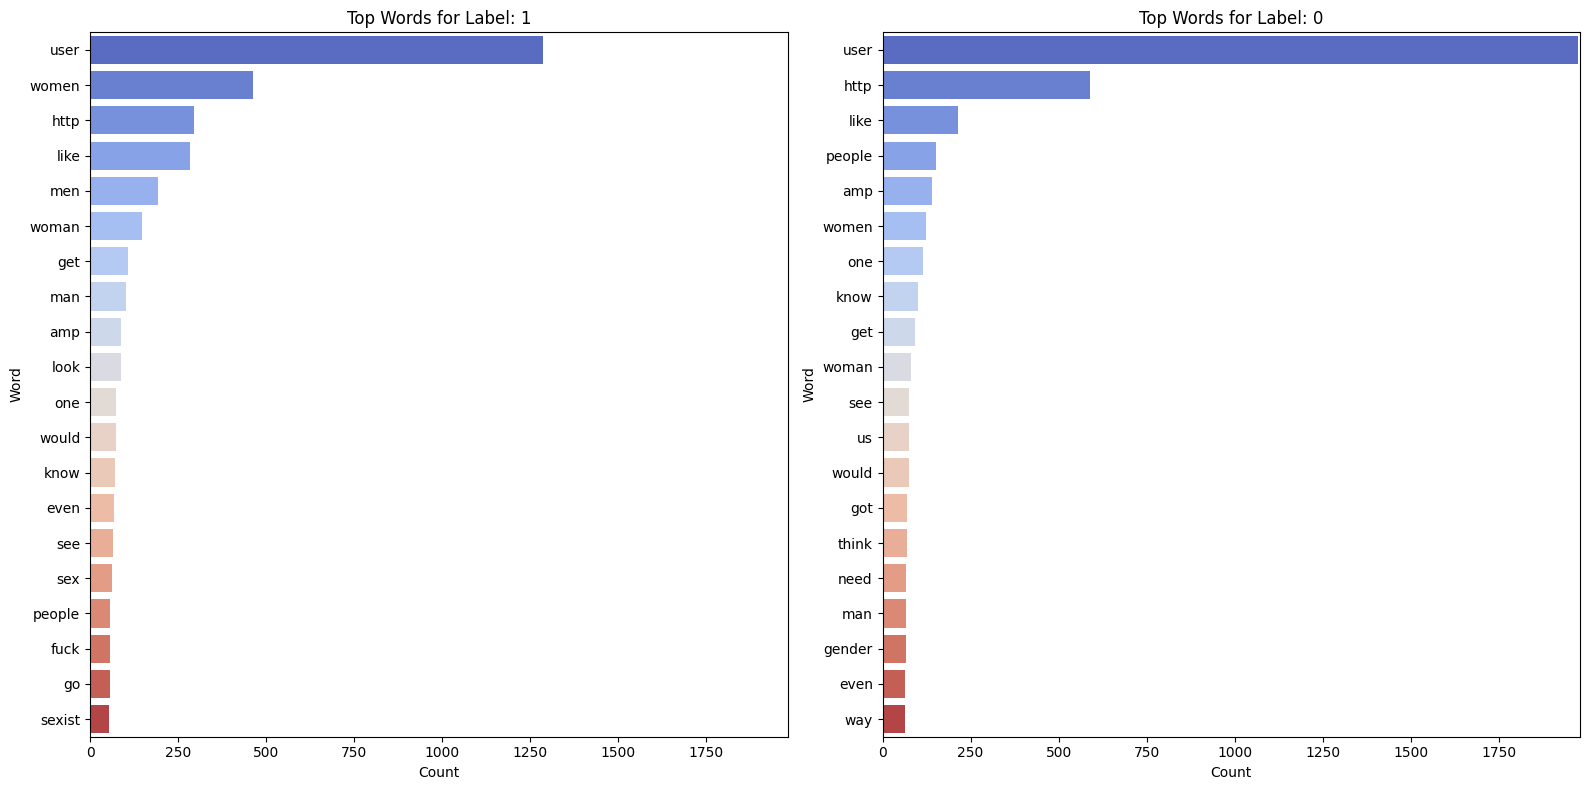

In [141]:
analyze_top_words_by_label(data_train, text_column='tweet', label_column='label', n_top_words=20)

Exclude some of the common words between the two labels to have a better understanding of the situation.

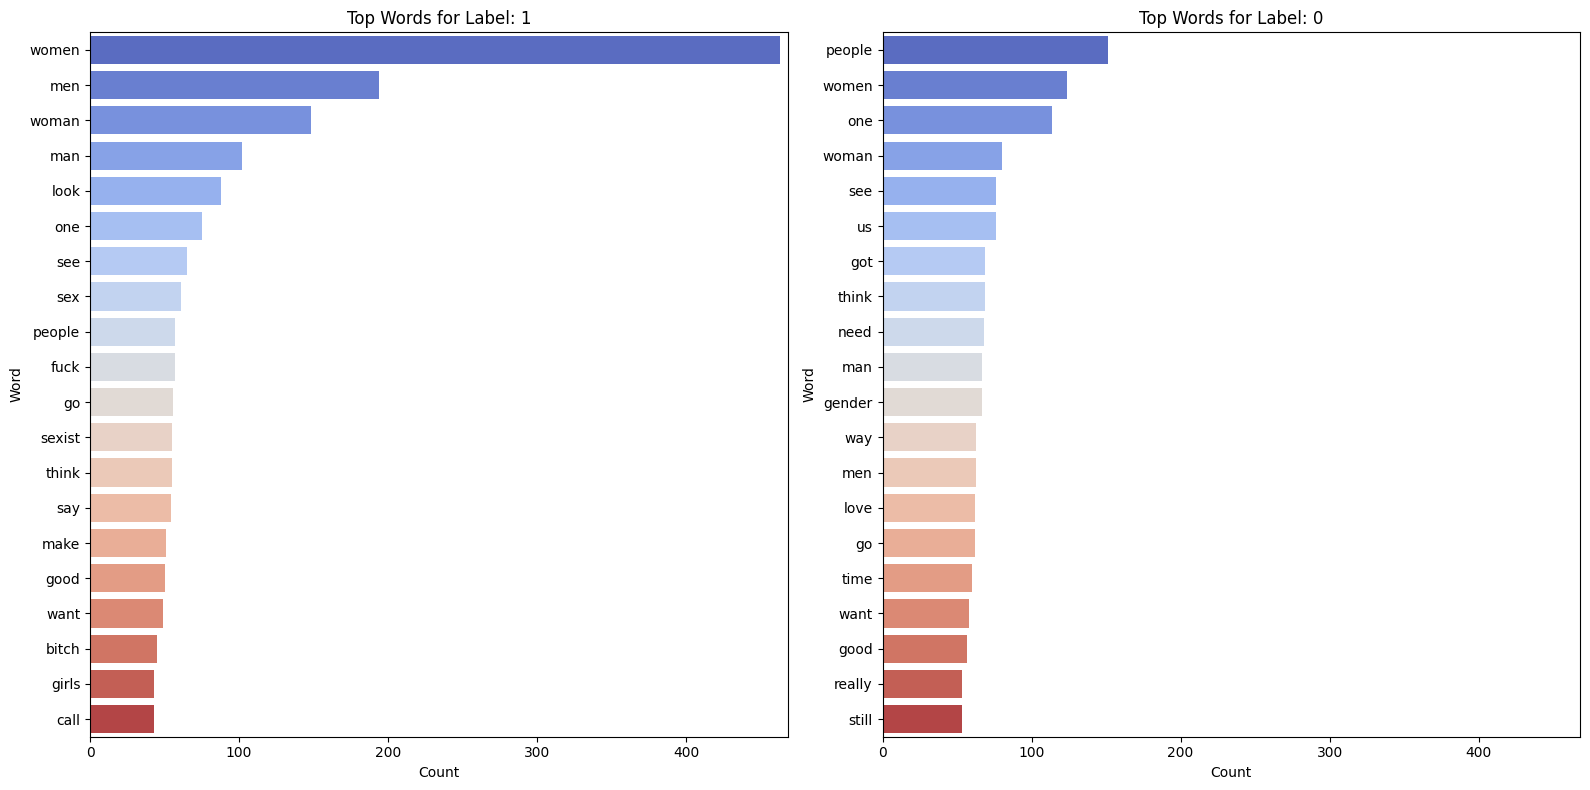

In [142]:
excluded_words = {'user', 'http', 'amp', 'like', 'get', 'know', 'would', 'even'}
analyze_top_words_by_label(data_train, text_column='tweet', label_column='label', n_top_words=20, excluded_words=excluded_words)

#### Confusion matrix and Precision-Recall curve


In [143]:
def plot_confusion_and_pr_curve(y_test, y_prob):
    """
    Given binary labels (y_true) and binary predictions (y_pred),
    this function will plot the confusion matrix, precision-recall curve,
    and classification report side by side.
    """
    #y_pred = np.argmax(y_prob, axis=-1)

    if y_prob.ndim == 2 and y_prob.shape[1] == 2:  # if y_prob is in shape (x, 2), probabilities for both classes
        y_pred = np.argmax(y_prob, axis=-1)  # Get predicted class
        y_prob_pos = y_prob[:, 1]  # Probabilities of the positive class
    elif y_prob.ndim == 1:  # if y_prob is in shape (x,), it represents predicted class labels directly
        y_pred = (y_prob >= 0.5).astype(int)  # Threshold at 0.5 to get predicted class (0 or 1)
        y_prob_pos = y_prob  # These are the probabilities for the positive class

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob_pos)

    # Create a figure with three subplots in one row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"], ax=ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")

    # Precision-Recall Curve
    ax2.plot(recall, precision, color="b", label="Precision-Recall Curve")
    ax2.fill_between(recall, precision, color="skyblue", alpha=0.4)
    ax2.set_title("Precision-Recall Curve")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.legend(loc="lower left")

    # Classification Report as a heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, fmt=".2f", cmap="Blues",
                cbar=True, xticklabels=report_df.columns, yticklabels=report_df.index, annot_kws={"size": 12}, ax=ax3)
    ax3.set_title("Classification Report")
    ax3.yaxis.set_tick_params(labelsize=10)
    ax3.set_xlabel("Metrics")

    # Adjust layout
    plt.tight_layout()
    plt.show()


Baseline model

DA METTERE A POSTO

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


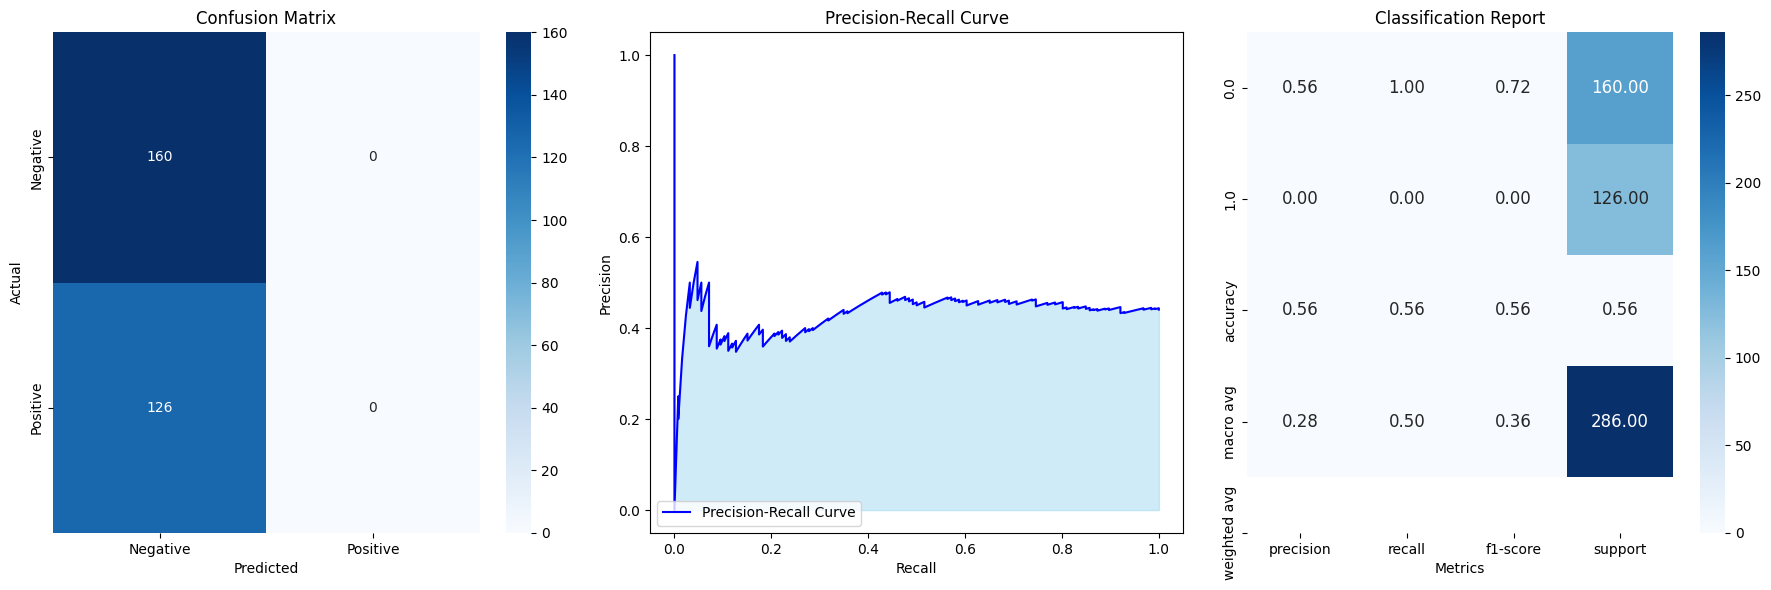

In [144]:
plot_confusion_and_pr_curve(baseline_labels, baseline_probs)

Model 1

DA METTERE A POSTO

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


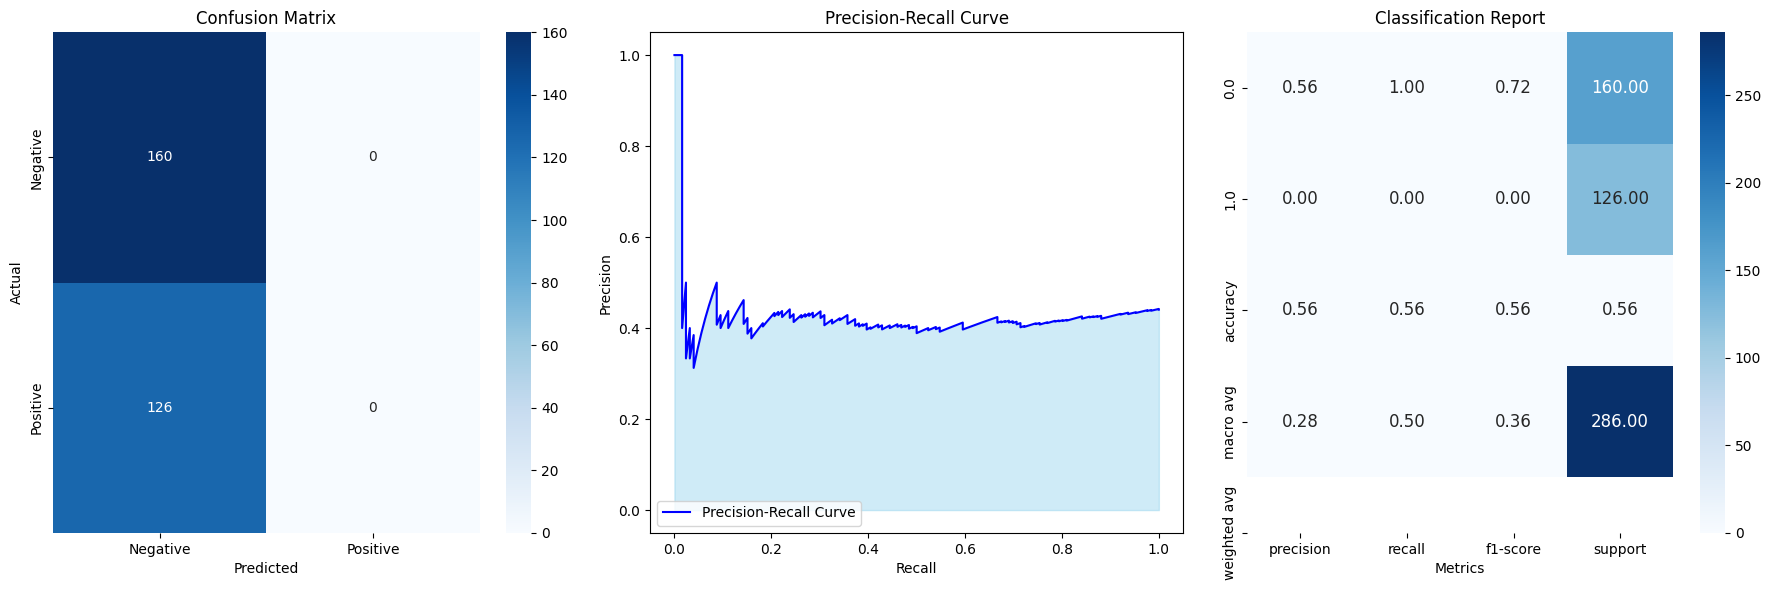

In [145]:
plot_confusion_and_pr_curve(model_1_labels, model_1_probs)

Transformer model

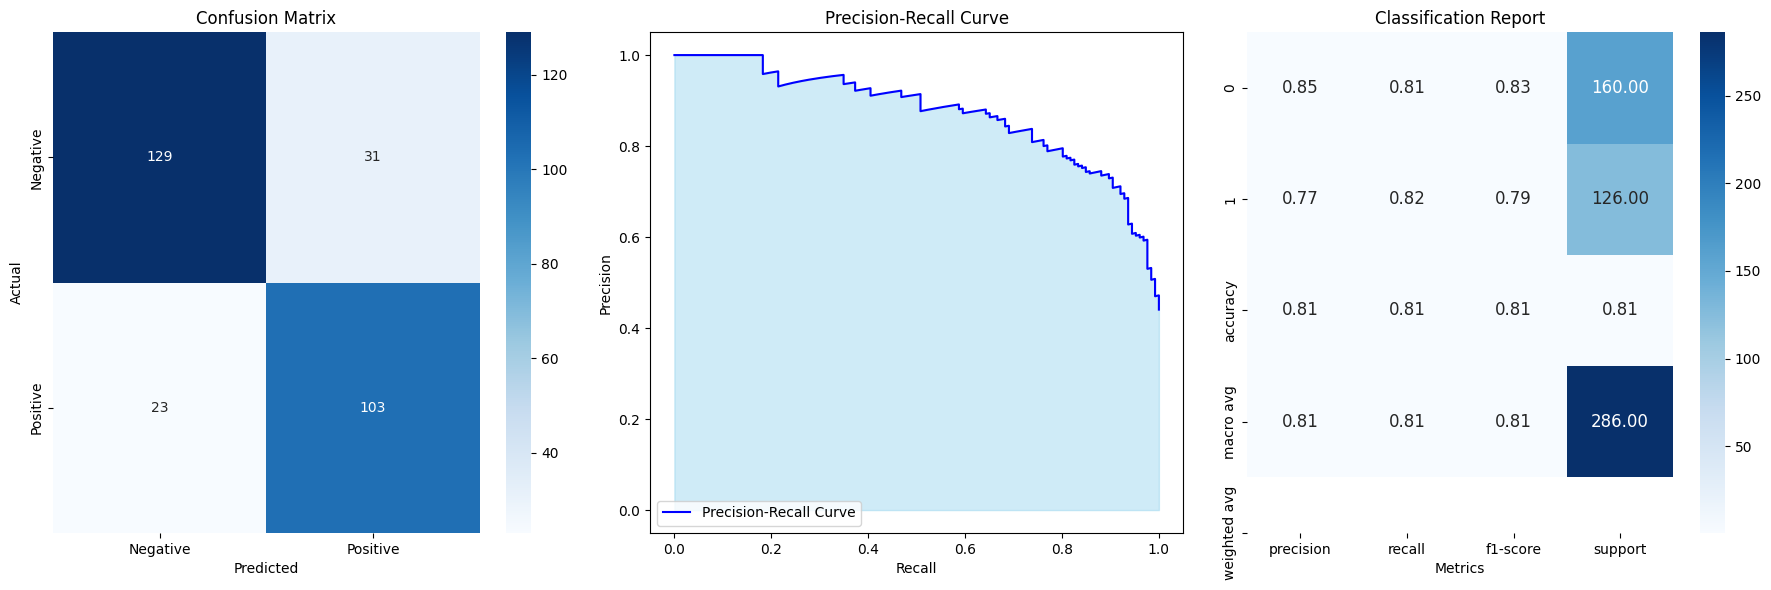

In [146]:
plot_confusion_and_pr_curve(transformer_test_labels, transformer_test_predictions)

#### Specific misclassified samples

In [147]:
def analyze_errors(text, pred, label, tokenizer):
    # Check if pred and label are of the same length
    if len(pred) != len(label):
        raise ValueError("The length of prediction and label lists must be the same.")

    # Initialize a list to store the results of incorrect predictions
    incorrect_preds = []
    output_list = []

    if len(pred.shape)>1:
        pred = np.argmax(pred, axis=-1)
    # Iterate through each token in the prediction and label
    for i in range(len(pred)):
        # If the prediction is incorrect, we'll process this token
        if pred[i] != label[i]:
            incorrect_preds.append((text[i], i))
            output_list.append((text[i], pred[i]))

    print(f"Number of incorrect prediction: {len(incorrect_preds)}")
    print("First dot reprsent label, second represent prediction, red means sexist")
    print("-----------------------------------------------------------------------------------")
    # If there are incorrect predictions, print them and color OOV tokens
    for err, idx in incorrect_preds:
        if label[idx] == 1:
            print("🔴", end=" ")
        else:
            print("🟢", end=" ")
        if pred[idx] == 1:
            print("🔴", end=" ")
        else:
            print("🟢", end=" ")
        print(err)

    return output_list

incpreds = analyze_errors(data_test['tweet'], transformer_test_predictions, transformer_test_labels, tokenizer)

Number of incorrect prediction: 54
First dot reprsent label, second represent prediction, red means sexist
-----------------------------------------------------------------------------------
🔴 🟢 Suika gets gangbanged to death http
🟢 🔴 @user @user Sex* as in 'gender' harassment is what they are inferring.
🟢 🔴 Isa hot girl summer now pop yall shit http
🟢 🔴 @user How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see who you Stan ? Are y'all ok ?? Your girls can't write can't deliver can't come close to bts's lyricism tf are y'all getting brave for ?? Fashion deals ??
🔴 🟢 @user @user @user That gold digger is nice but the picture and set up for them are elite. Pinwork is like the revealing of the Mona Lisa. Always a work of art.
🟢 🔴 @user Well let me ask for the guys… do you ever just grab your testicles because you can?
🔴 🟢 Dear @user fans Can we not harass talented actors of color? Stop being racist douche nozzles. This is why we can't have 

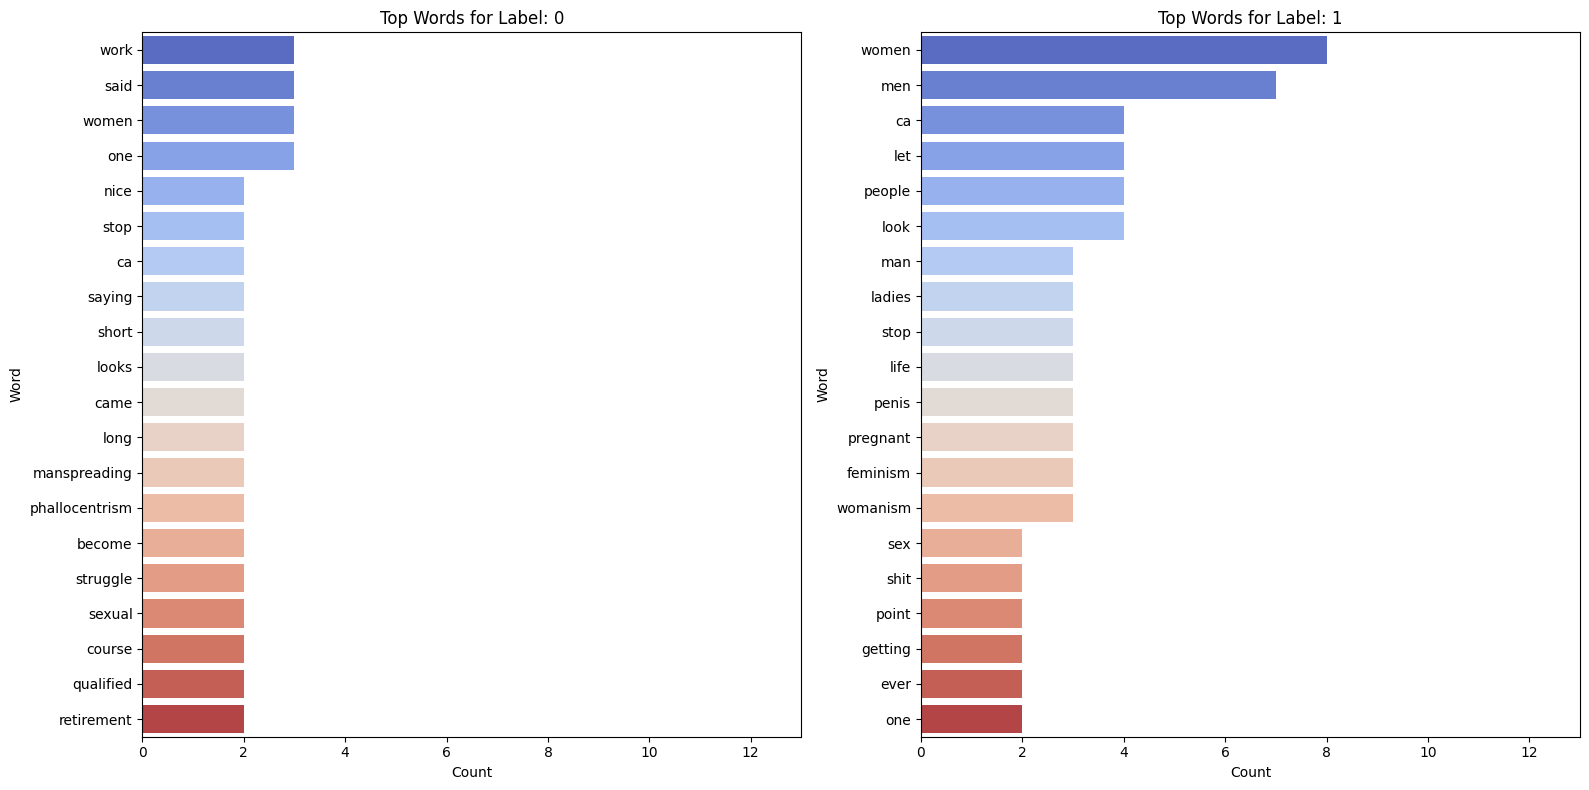

In [148]:
errors_df = pd.DataFrame(incpreds, columns=["tweet", "label"])
analyze_top_words_by_label(errors_df, text_column='tweet', label_column='label', n_top_words=20, excluded_words=excluded_words)

Top words for baseline model

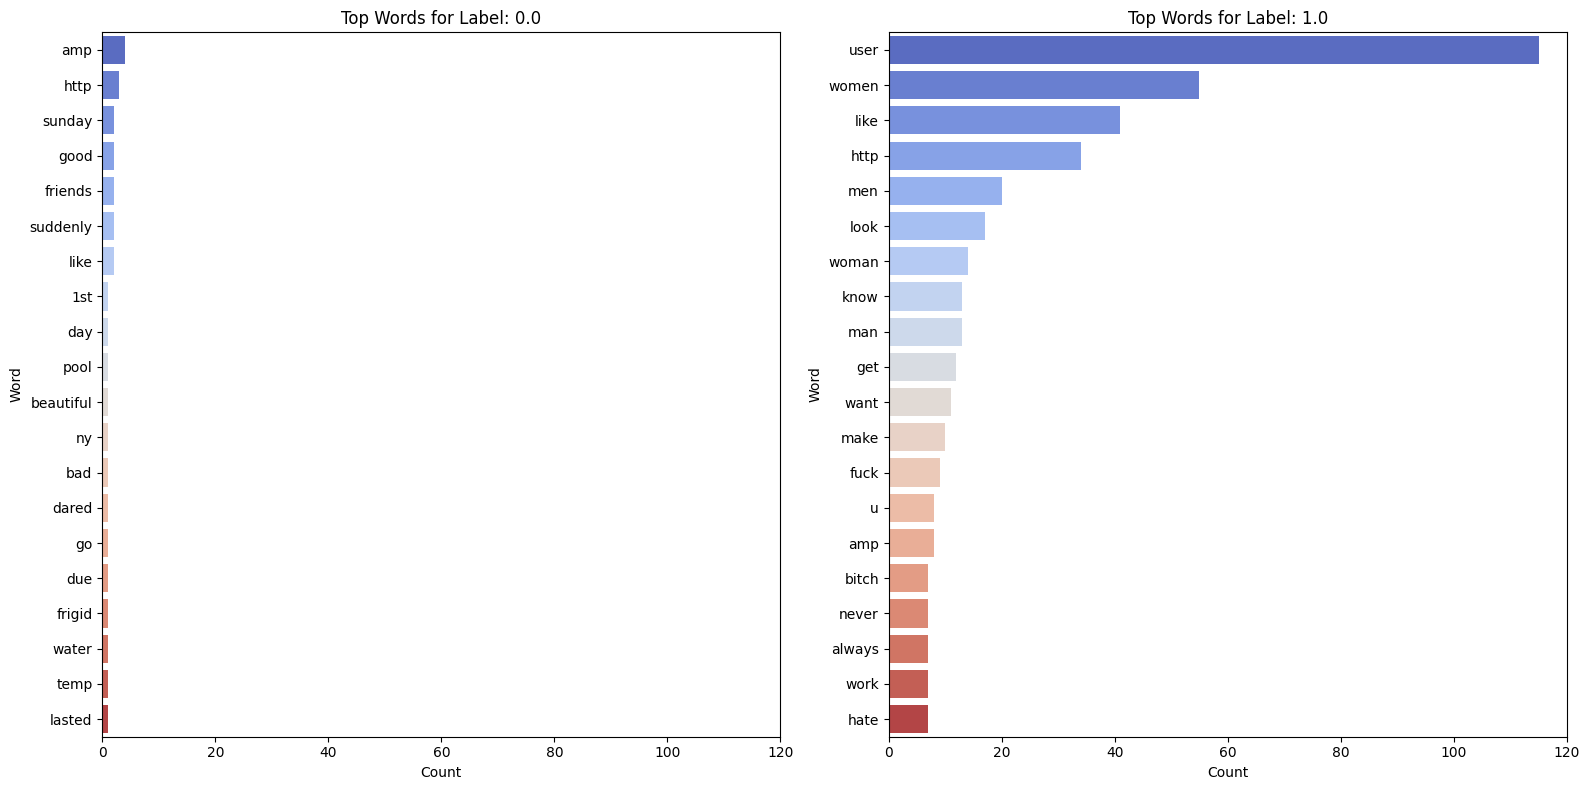

In [149]:
analyze_top_words_by_label(baseline_error_df, text_column='tweet', label_column='label', n_top_words=20)

Top words for model 1

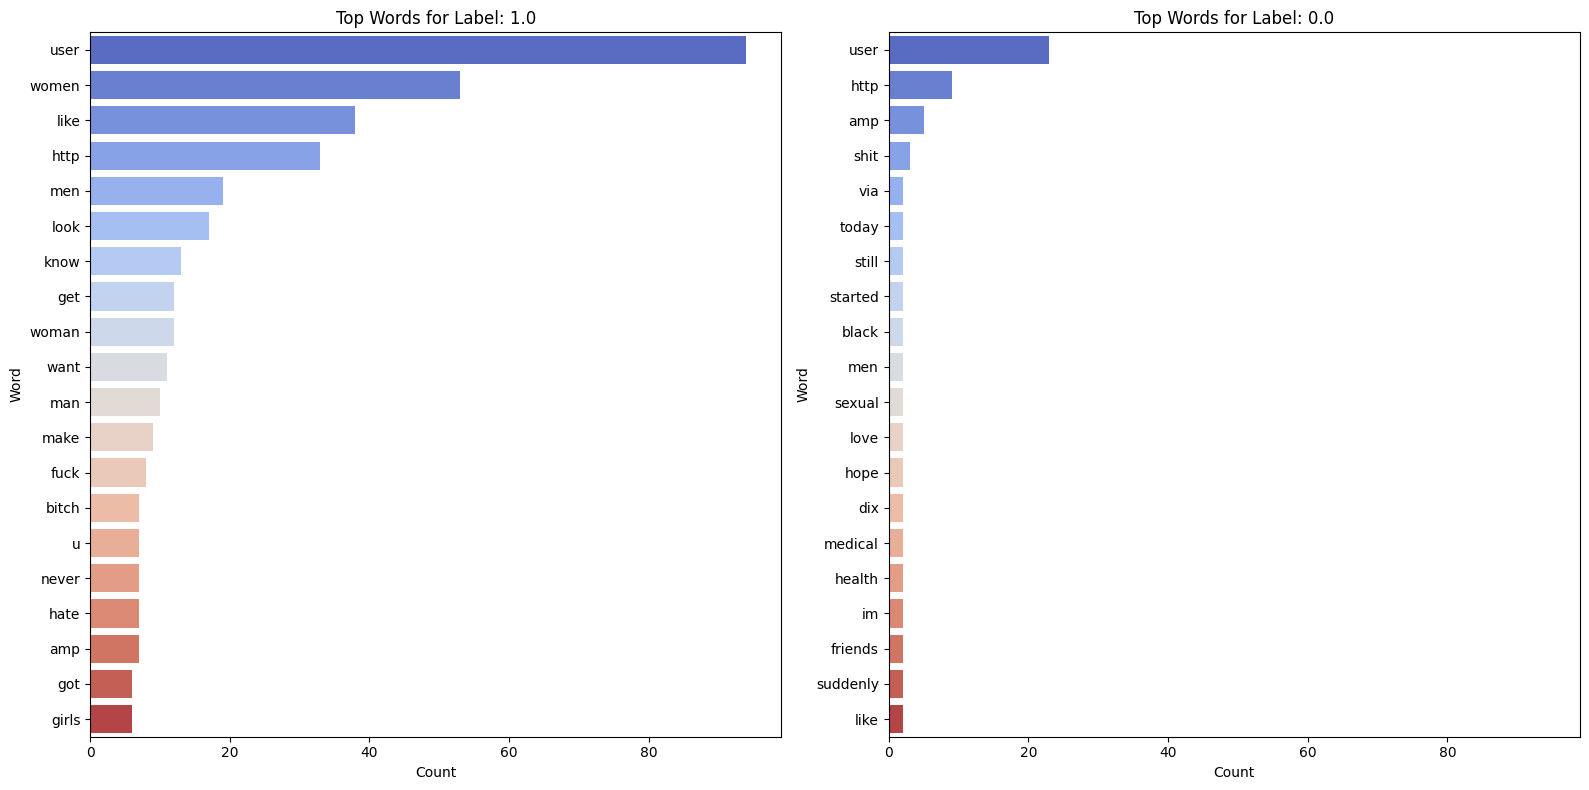

In [150]:
analyze_top_words_by_label(model_1_error_df, text_column='tweet', label_column='label', n_top_words=20)

In [151]:
def highlight_oov_tokens(df, vocabulary, tweet_column="tweet", label_column="label", oov_column="oov_token_count"):
    # Extract vocabulary keys
    vocab_keys = set(vocabulary.keys())

    def highlight_tokens(tweet):
        """Highlight OOV tokens in red within the tweet."""
        tokens = tweet.split()  # Assuming tweets are space-separated strings
        highlighted = [
            f"\033[91m{token}\033[0m" if token not in vocab_keys else token
            for token in tokens
        ]
        return " ".join(highlighted)

    print(f"\n{'Label':<6}{'Tweet (OOV tokens highlighted in red)':<60}")
    print("-" * 70)

    for _, row in df.iterrows():
        label = row[label_column]
        tweet = row[tweet_column]
        label_emoji = "🔴" if label == 1 else "🟢"
        highlighted_tweet = highlight_tokens(tweet)
        print(f"{label_emoji:<6}{highlighted_tweet}")

highlight_oov_tokens(baseline_error_df, vocab, tweet_column="tweet", label_column="label", oov_column="oov_token_count")


Label Tweet (OOV tokens highlighted in red)                       
----------------------------------------------------------------------
🟢     1st day at the pool on a beautiful Sunday in NY! Too bad few dared to go in due to the frigid water temp (we lasted 45 min and figured we proved our point) 😆 http
🔴     “I like your outfit too except when i dress up as a frigid bitch, i try not to look so constipated” is my new “how are you?”
🔴     @user @user Fuck that cunt. Tried to vote her out multiple times
🔴     @user u gotta say some shit like “i’ll fuck that cunt dumb until you can’t remember anything but my name you stupid slut”
🔴     @user “Mmm, fuck that cunt is hungry for this dick isn’t it~ Such a shame that you can lie all you want about not wanting this but your body never can~”He says in her ear before he starts kissing down her neck. Making sure to leave plenty of love marks on her pale skin.
🔴     Suika gets gangbanged to death http
🔴     @user Maybe something involving her g

In [152]:
highlight_oov_tokens(model_1_error_df, vocab, tweet_column="tweet", label_column="label", oov_column="oov_token_count")


Label Tweet (OOV tokens highlighted in red)                       
----------------------------------------------------------------------
🔴     “I like your outfit too except when i dress up as a frigid bitch, i try not to look so constipated” is my new “how are you?”
🔴     @user @user Fuck that cunt. Tried to vote her out multiple times
🔴     @user u gotta say some shit like “i’ll fuck that cunt dumb until you can’t remember anything but my name you stupid slut”
🔴     @user “Mmm, fuck that cunt is hungry for this dick isn’t it~ Such a shame that you can lie all you want about not wanting this but your body never can~”He says in her ear before he starts kissing down her neck. Making sure to leave plenty of love marks on her pale skin.
🔴     Suika gets gangbanged to death http
🔴     @user Maybe something involving her getting gangbanged~?
🔴     @user Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing "gender harassment".Female students wi

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End